# BERT Model for Multi-label Text Classification

In this notebook, we will train a BERT model to classify text into multiple categories of toxicity. We will use the `transformers` library to access pre-trained BERT models and fine-tune them for our specific task.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!pip install -U -q PyDrive

In [15]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
file_id = '1uz_1CXxikbANHl43_jRkOOsPUdh263EI'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('bert_toxic_model.pth')

In [16]:
!gdown --id 1uz_1CXxikbANHl43_jRkOOsPUdh263EI

Access denied with the following error:


C:\Users\tonio\anaconda3\envs\tonio_env3.11\Lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1uz_1CXxikbANHl43_jRkOOsPUdh263EI 



In [7]:
# Import necessary libraries
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.optim.lr_scheduler import StepLR
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast  # Import AMP support
import numpy as np
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tonio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tonio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tonio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset Preparation

We will define a custom dataset class that will handle the tokenization of the text and prepare it for input into the BERT model.

In [8]:
import re
from nltk.stem.snowball import SnowballStemmer

# Define the regex patterns
special_character_removal = re.compile(r'[^?!.,:a-z\d ]', re.IGNORECASE)
replace_numbers = re.compile(r'\d+', re.IGNORECASE)

def preprocess_text(text, stem_words=False):
    # Lowercase
    text = text.lower()

    # Remove URLs and IPs
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)

    # Remove Wiki Markup and other patterns
    text = re.sub(r"image:[a-zA-Z0-9]*\.(jpg|png|gif|bmp)", " ", text)
    text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ", text)
    text = re.sub(r"\{\|[^\}]*\|\}", " ", text)
    text = re.sub(r"\[?\[user:.*\]", " ", text)
    text = re.sub(r"\[?\[wikipedia:.*\]", " ", text)
    text = re.sub(r"\[?\[special:.*\]", " ", text)
    text = re.sub(r"\[?\[category:.*\]", " ", text)

    # Replace common abbreviations and punctuation
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = replace_numbers.sub(' ', text)
    text = special_character_removal.sub('', text)

    # Remove extra spaces
    text = re.sub(r"\s{2,}", " ", text)

    # Optionally, stem words
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)

    return text

In [9]:
class BERTDataset:
    def __init__(self, texts, labels, max_len=128):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.float)
        self.max_len = max_len
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.num_examples = len(self.texts)

    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
      text = str(self.texts[idx])
      # Preprocess the text
      preprocessed_text = preprocess_text(text)
      label = self.labels[idx]
      tokenized_text = self.tokenizer(
          preprocessed_text,  # Use the preprocessed text here
          add_special_tokens=True,
          padding="max_length",
          max_length=self.max_len,
          truncation=True,
          return_tensors='pt'
      )
      ids = tokenized_text["input_ids"].squeeze()
      mask = tokenized_text["attention_mask"].squeeze()
      token_type_ids = tokenized_text["token_type_ids"].squeeze()

      return {
        "ids": ids,
        "mask": mask,
        "token_type_ids": token_type_ids,
        "target": label.clone().detach().requires_grad_(False),
    }

## Model Definition

We will define a BERT model for our multi-label classification problem.

In [10]:
class BertToxicModel(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_labels=6):
        super(BertToxicModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name, return_dict=False)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, token_type_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

## Metrics Calculation

We will define a function to calculate the accuracy, precision, recall, and F1 score of our model's predictions.

In [11]:
def calculate_metrics(logits, targets):
    preds = torch.sigmoid(logits).cpu().detach().numpy().round()
    targets = targets.cpu().detach().numpy()

    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average='micro', zero_division=1)
    recall = recall_score(targets, preds, average='micro', zero_division=1)
    f1 = f1_score(targets, preds, average='micro', zero_division=1)

    return accuracy, precision, recall, f1

## Training and Evaluation Function

We will define a function to handle the training and evaluation of our model.

In [12]:
from torch.utils.tensorboard import SummaryWriter
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

def train_and_evaluate(model, train_data_loader, valid_data_loader, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # Before initializing SummaryWriter, specify the log directory
    log_dir = '/content/drive/MyDrive/tensorboard_logs'
    writer = SummaryWriter(log_dir=log_dir)

    train_losses = []
    valid_losses = []
    train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    valid_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    best_valid_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{epochs} Training"):
            optimizer.zero_grad()
            ids = batch["ids"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            mask = batch["mask"].to(device)
            targets = batch["target"].to(device)
            logits = model(ids, token_type_ids, mask)
            loss = criterion(logits, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * ids.size(0)

            # Calculate training metrics
            train_acc, train_prec, train_rec, train_f1 = calculate_metrics(logits, targets)
            train_metrics['accuracy'].append(train_acc)
            train_metrics['precision'].append(train_prec)
            train_metrics['recall'].append(train_rec)
            train_metrics['f1'].append(train_f1)

        train_loss /= len(train_data_loader.dataset)
        train_losses.append(train_loss)

        # Log training metrics to TensorBoard
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Accuracy/Train', np.mean(train_metrics['accuracy']), epoch)
        writer.add_scalar('Precision/Train', np.mean(train_metrics['precision']), epoch)
        writer.add_scalar('Recall/Train', np.mean(train_metrics['recall']), epoch)
        writer.add_scalar('F1/Train', np.mean(train_metrics['f1']), epoch)

        # Validation phase begins here
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for batch in tqdm(valid_data_loader, desc=f"Epoch {epoch+1}/{epochs} Validation"):
                ids = batch["ids"].to(device)
                token_type_ids = batch["token_type_ids"].to(device)
                mask = batch["mask"].to(device)
                targets = batch["target"].to(device)
                logits = model(ids, token_type_ids, mask)
                loss = criterion(logits, targets)

                valid_loss += loss.item() * ids.size(0)

                # Calculate validation metrics
                valid_acc, valid_prec, valid_rec, valid_f1 = calculate_metrics(logits, targets)
                valid_metrics['accuracy'].append(valid_acc)
                valid_metrics['precision'].append(valid_prec)
                valid_metrics['recall'].append(valid_rec)
                valid_metrics['f1'].append(valid_f1)

        valid_loss /= len(valid_data_loader.dataset)
        valid_losses.append(valid_loss)

        # Log validation metrics to TensorBoard
        writer.add_scalar('Loss/Valid', valid_loss, epoch)
        writer.add_scalar('Accuracy/Valid', np.mean(valid_metrics['accuracy']), epoch)
        writer.add_scalar('Precision/Valid', np.mean(valid_metrics['precision']), epoch)
        writer.add_scalar('Recall/Valid', np.mean(valid_metrics['recall']), epoch)
        writer.add_scalar('F1/Valid', np.mean(valid_metrics['f1']), epoch)

        # Save the model if it has the lowest validation loss so far
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/bert_toxic_model_best.pth')
            print(f"Epoch {epoch+1}: Model saved with lowest validation loss: {valid_loss}")

        # Save the model after every 2 epochs
        if (epoch + 1) % 2 == 0:
            torch.save(model.state_dict(), f'/content/drive/MyDrive/bert_toxic_model_epoch_{epoch+1}.pth')
            print(f"Epoch {epoch+1}: Checkpoint saved")

    writer.close()

    return train_losses, valid_losses, train_metrics, valid_metrics

In [13]:
# df = pd.read_csv('/content/drive/MyDrive/train.csv') # Uncomment for notebook
df = pd.read_csv('data/train.csv') # For local

In [14]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = df[target_columns].values

In [15]:
class_counts = df[target_columns].sum().sort_values()
print(class_counts)

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64


## Visualization of the words in the different toxic categories

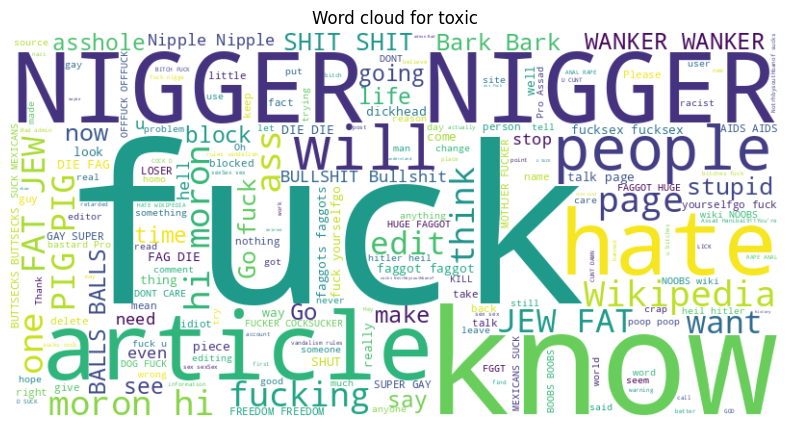

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate a word cloud for a specified category
def generate_word_cloud(df, category):
    text = df[df[category] == 1]['comment_text'].str.cat(sep=' ')
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word cloud for {category}')
    plt.show()

category = 'toxic'  # Replace with the category of interest
generate_word_cloud(df, category)

In [16]:
# Split the data into training and validation sets (80% train, 20% validation)
df_train, df_valid, train_labels, valid_labels = train_test_split(
    df.comment_text.values,
    labels,
    test_size=0.20,  # 20% for validation
    random_state=42  # Seed for reproducibility
)

In [17]:
# Create datasets
train_dataset = BERTDataset(df_train, train_labels)
valid_dataset = BERTDataset(df_valid, valid_labels)

In [14]:
# Create data loaders
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

In [15]:
# Initialize the model
model = BertToxicModel()
epochs=4

In [16]:
# Train the model and evaluate
train_losses, valid_losses, train_metrics, valid_metrics = train_and_evaluate(
    model, train_data_loader, valid_data_loader, epochs=epochs)

Epoch 1/4 Training:   0%|          | 0/998 [00:00<?, ?it/s]

Epoch 1/4 Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: Model saved with lowest validation loss: 0.0818497152660248


Epoch 2/4 Training:   0%|          | 0/998 [00:00<?, ?it/s]

Epoch 2/4 Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: Checkpoint saved


Epoch 3/4 Training:   0%|          | 0/998 [00:00<?, ?it/s]

Epoch 3/4 Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: Model saved with lowest validation loss: 0.07596580073641289


Epoch 4/4 Training:   0%|          | 0/998 [00:00<?, ?it/s]

Epoch 4/4 Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4: Checkpoint saved


In [18]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/bert_toxic_model.pth')

In [ ]:
# Launch TensorBoard
%load_ext tensorboard
%tensorboard --logdir .


## PREDICTION.PY FILE RAN IN ONE CELL

In [23]:
import sys
from PyQt5.QtWidgets import (
    QApplication,
    QMainWindow,
    QPushButton,
    QTextEdit,
    QVBoxLayout,
    QWidget,
    QDialog,
    QProgressBar, 
    QMessageBox,
)

from PyQt5.QtGui import QFont
from PyQt5.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from transformers import BertTokenizer
import torch
from bert_train import BertToxicModel
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import threading
import time
import webbrowser

# Set TensorFlow logging to avoid unnecessary warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Initialize the Bert model
model_path = "bert_toxic_model.pth"
model = BertToxicModel()
# Load the state dictionary, ignoring missing keys
state_dict = torch.load(model_path, map_location=torch.device("cpu"))
try:
    model.load_state_dict(state_dict)
except RuntimeError as e:
    print(f"RuntimeError: {e}")
model.eval()

class BarChartWindow(QDialog):
    def __init__(self, parent=None):
        super().__init__(parent)
        self.setWindowTitle("Toxic Classification Counts")
        self.setGeometry(300, 300, 600, 400)  # Set the window size
        layout = QVBoxLayout()
        self.setLayout(layout)
        self.canvas = FigureCanvas(Figure())
        layout.addWidget(self.canvas)

    def draw_chart(self, sums):
        ax = self.canvas.figure.subplots()
        ax.clear()
        sns.barplot(x=sums.index, y=sums.values, ax=ax)
        ax.set_title('Toxic Classification Counts')
        ax.set_ylabel('Counts')
        ax.set_xlabel('Categories')
        self.canvas.draw()


# Define the predict function
def predict(model, text, max_len=128):
    model.eval()
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    tokenized_text = tokenizer(
        text,
        add_special_tokens=True,
        padding="max_length",
        max_length=max_len,
        truncation=True,
        return_tensors="pt",
    )
    ids = tokenized_text["input_ids"]
    mask = tokenized_text["attention_mask"]
    token_type_ids = tokenized_text["token_type_ids"]

    with torch.no_grad():
        logits = model(ids, token_type_ids, mask)
        predictions = torch.sigmoid(logits).cpu().numpy()

    return predictions


# Main Application Window
class App(QMainWindow):
    def __init__(self):
        super().__init__()
        self.title = "Toxic Comment Prediction with Metrics"
        self.initUI()

    def initUI(self):
        self.setWindowTitle(self.title)
        self.setGeometry(100, 100, 800, 600)
        self.setMinimumSize(600, 400)  # Ensure a minimum window size for proper layout

        # Main widget and layout
        self.widget = QWidget(self)
        self.setCentralWidget(self.widget)
        self.layout = QVBoxLayout()
        self.widget.setLayout(self.layout)

        # Inside the initUI method of the App class
        self.tensorboard_button = QPushButton("Show TensorBoard Metrics", self)
        self.tensorboard_button.clicked.connect(self.show_tensorboard)
        self.layout.addWidget(self.tensorboard_button)

        # Text input with placeholder and monospace font
        self.text_input = QTextEdit(self)
        self.text_input.setFont(QFont("Consolas", 10))  # Easier to read font
        self.text_input.setPlaceholderText("Enter text here...")
        self.layout.addWidget(self.text_input)

        # Predict button with style
        self.predict_button = QPushButton("Predict", self)
        self.predict_button.setFont(QFont("Arial", 11, QFont.Bold))
        self.predict_button.setStyleSheet("background-color: #4CAF50; color: white;")
        self.predict_button.clicked.connect(self.on_predict)
        self.layout.addWidget(self.predict_button)

        # Bar Chart button
        self.bar_chart_button = QPushButton("Bar Chart", self)
        self.bar_chart_button.clicked.connect(self.show_bar_chart)
        self.layout.addWidget(self.bar_chart_button)

        # Matplotlib graph
        self.canvas = FigureCanvas(Figure())
        self.layout.addWidget(self.canvas)
        self.add_plot()

    def show_tensorboard(self):
        # Define the TensorBoard URL, usually it runs on localhost at port 6006
        tensorboard_url = 'http://localhost:6006/'
        # Launch TensorBoard in a separate thread to avoid blocking the PyQt5 app
        current_dir = os.path.dirname(os.path.abspath(__file__))
        threading.Thread(target=lambda: os.system(f'tensorboard --logdir="{current_dir}"')).start()
        # Inform the user that TensorBoard is loading and may take a few seconds
        QMessageBox.information(self, "TensorBoard Loading", "Please wait for 5 seconds for the metrics to load in your broswer.")
        # Give TensorBoard a few seconds to start
        time.sleep(5)
        # Open the TensorBoard URL in the default web browser
        webbrowser.open(tensorboard_url)

    def show_bar_chart(self):
        df = pd.read_csv('data/train.csv')
        sums = df.iloc[:, 2:].sum()
        self.bar_chart_window = BarChartWindow(self)  # Create a new window instance
        self.bar_chart_window.draw_chart(sums)  # Draw the chart
        self.bar_chart_window.show()

    def add_plot(self, percentages=None):
        ax = self.canvas.figure.subplots()
        ax.clear()  # Clear the previous plot
        if percentages is not None:
            categories = [
                "Toxic",
                "Severe Toxic",
                "Obscene",
                "Threat",
                "Insult",
                "Identity Hate",
            ]
            y_pos = np.arange(len(categories))
            bars = ax.bar(
                y_pos, percentages, align="center", alpha=0.7, color="#007ACC"
            )

            # Add labels and title with increased font sizes
            ax.set_xticks(y_pos)
            ax.set_xticklabels(categories, rotation=45, ha="right", fontsize=10)
            ax.set_ylabel("Percentages", fontsize=12)
            ax.set_title("Toxic Comment Prediction Percentages", fontsize=14)

            # Set y-axis range to 0-100%
            ax.set_ylim(0, 100)

            # Add the percentage above the bars
            for bar in bars:
                height = bar.get_height()
                ax.annotate(
                    f"{height:.2f}%",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

            # Add a soft grid
            ax.grid(True, color="grey", linestyle="--", linewidth=0.5, alpha=0.7)
            ax.set_axisbelow(True)

            # Set background color for the axes and the figure
            ax.set_facecolor("#F8F8F8")
            self.canvas.figure.set_facecolor("#F8F8F8")

            # Manually adjust the margins and improve layout
            self.canvas.figure.subplots_adjust(
                bottom=0.2, top=0.9, left=0.1, right=0.95
            )

            self.canvas.draw()

    def on_predict(self):
        input_text = self.text_input.toPlainText()
        prediction = predict(model, input_text)
        percentages = prediction[0] * 100
        self.add_plot(percentages)  # Update the plot with new percentages

if __name__ == "__main__":
    app = QApplication(sys.argv)
    ex = App()
    ex.show()
    sys.exit(app.exec_())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: Error(s) in loading state_dict for BertToxicModel:
	Missing key(s) in state_dict: "bert.embeddings.position_ids". 


SystemExit: 0

c:\Users\tonio\anaconda3\envs\tonio_env3.11\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
